# Import Library

In [35]:
import pandas as pd
import sqlite3
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display
import os
from dotenv import load_dotenv
import firebase_admin
from firebase_admin import credentials, storage
from sklearn.preprocessing import MinMaxScaler

# Extract Data

In [36]:
# From csv
electricity_access_precent = pd.read_csv('DataSource/electricity_access_precent.csv', quotechar='"')

rural_population_percent = pd.read_csv("DataSource/rural_population_percent.csv", quotechar='"')

gdp_data = pd.read_csv('DataSource/gdp_data.csv', quotechar='"')

mystery = pd.read_csv('DataSource/mystery.csv', quotechar='"', encoding='utf-16')

population_data_from_csv = pd.read_csv('DataSource/population_data.csv', quotechar='"')

projects_data = pd.read_csv("DataSource/projects_data.csv", quotechar='"')


# From json
population_data_from_json = pd.read_json('DataSource/population_data.json')


# From db
conn = sqlite3.connect('DataSource/population_data.db')
population_data_from_db = pd.read_sql_query("SELECT * FROM population_data;", conn)
conn.close()


# From xml
with open("DataSource/population_data.xml", "r") as f:
    xml_data = f.read()

soup = BeautifulSoup(xml_data, "xml")
data = []
for record in soup.find_all("record"):
    record_data = {}
    for field in record.find_all("field"):
        name = field.get("name")
        value = field.text
        key = field.get("key")  
        record_data[name] = value
        if name != "Year" and name != "Value": 
            record_data[name+"_key"] = key  
    data.append(record_data)

population_data_from_xml = pd.DataFrame(data)

# from API
url = f"https://api.worldbank.org/v2/countries/all/indicators/SP.POP.TOTL/?format=json&per_page=1000"
data = []
page = 1
total_pages = None

while total_pages is None or page <= total_pages:
    response = requests.get(url, params={"page": page})
    response_data = response.json()
    if total_pages is None:
        total_pages = response_data[0]['pages']
    data.extend(response_data[1])
    page += 1

df_worldbank = pd.json_normalize(data)

C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\2020535736.py:12: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  projects_data = pd.read_csv("DataSource/projects_data.csv", quotechar='"')


# Transfrom

#### - Check Duplicate

In [37]:
def check_duplicate (data):
    duplicate_rows = data[data.duplicated(keep=False)]
    print(duplicate_rows)

check_duplicate(electricity_access_precent)
check_duplicate(gdp_data)
check_duplicate(mystery)
check_duplicate(population_data_from_csv)
check_duplicate(population_data_from_db)
check_duplicate(population_data_from_json)
check_duplicate(population_data_from_xml)
check_duplicate(projects_data)
check_duplicate(rural_population_percent)
check_duplicate(df_worldbank)

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, Unnamed: 62]
Index: []

[0 rows x 63 columns]
Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, Unnamed: 62]
Index: []

[0 rows x 63 columns]
Empty DataFrame
Columns: [Unnamed: 0, Co

#### - Handle Missing Value

In [38]:
def handle_missing_value_by_column(data, percent):
    total_row = len(data)
    missing_values = data.isnull().sum()
    zero_values = (data == 0).sum()
    total_missing_or_zero = missing_values + zero_values
    missing_percentage = (total_missing_or_zero/ total_row) * 100
    columns_to_drop = missing_percentage[missing_percentage > percent].index 
    data.drop(columns=columns_to_drop, inplace=True)
    return data
                
def handle_missing_value_by_row(data, column_param, percent) :
    index = data.columns.get_loc(column_param) ## ambil index dari kolom pembatas
    cek_kolom = data.columns[index + 1:]
    jumlah_cek_kolom = len(cek_kolom)
    drop_rows = []
    for index, row in data.iterrows() :
        missing_values = row[cek_kolom].isna().sum()
        missing_percent = (missing_values/jumlah_cek_kolom)*100
        if missing_percent > percent :
                drop_rows.append(index)
        else:
            row[cek_kolom] = row[cek_kolom].replace(0, pd.NA)
            numeric_row = row[cek_kolom].apply(pd.to_numeric, errors='coerce')
            mean_row = numeric_row.mean()
            data.loc[index, cek_kolom] = numeric_row.fillna(mean_row)
    data.drop(index=drop_rows, inplace=True)
    return data

#### - renameColumn_replace_sort

In [39]:
def renameColumn_replace_sort(df, column1, column2, column3, column4, valueName):
    df = df.rename(columns={column1:'country_name',column2:'country_code', column3:'indicator_name',column4:'indicator_code'})
    df = df.melt(id_vars=["country_name","country_code","indicator_name","indicator_code"], var_name='year', value_name=valueName)
    df = df.sort_values(by=['country_name', 'year'])
    return df

#### 1. electricity_access_percent

In [40]:
df = electricity_access_precent
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df, 'Indicator Code', 20)
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','electricity_access_percent')
electricity_access_precent=df
electricity_access_precent

,country_name,country_code,indicator_name,indicator_code,year,electricity_access_percent
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1990,0.010000
257,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1991,0.010000
513,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1992,0.010000
769,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1993,0.010000
1025,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,1994,0.010000
...,...,...,...,...,...,...
5887,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2012,36.728878
6143,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2013,37.076813
6399,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2014,32.300000
6655,Zimbabwe,ZWE,Access to electricity (% of population),EG.ELC.ACCS.ZS,2015,33.700000


#### 2. rural_population_percent

In [41]:
df = rural_population_percent
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df, 'Indicator Code', 20)
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','rural_population_percent')
rural_population_percent=df
rural_population_percent

,country_name,country_code,indicator_name,indicator_code,year,rural_population_percent
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1960,91.779
260,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1961,91.492
519,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1962,91.195
778,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1963,90.890
1037,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1964,90.574
...,...,...,...,...,...,...
13985,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2013,67.346
14244,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2014,67.499
14503,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2015,67.624
14762,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2016,67.723


#### 3. All Population Data

In [43]:
# csv
df = population_data_from_csv
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df,'Indicator Code', 20)
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','population')
df['indicator_name'] = df['indicator_name'].str.replace('Population, total', 'Population total')
population_data_from_csv = df
display(population_data_from_csv)

# json
df = population_data_from_json
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df,'Indicator Code', 20)
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','population')
df['indicator_name'] = df['indicator_name'].str.replace('Population, total', 'Population total')
population_data_from_json = df
display(population_data_from_json)

# db
df = population_data_from_db
df = df.drop(columns=['index'])
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df,'Indicator_Code', 20)
df = renameColumn_replace_sort(df, 'Country_Name', 'Country_Code','Indicator_Name','Indicator_Code','population')
df['indicator_name'] = df['indicator_name'].str.replace('Population, total', 'Population total')
population_data_from_db = df
display(population_data_from_db)

# xml
df = population_data_from_xml
drop_countries = ['Not classified', 'Eritrea', 'Kuwait', 'West Bank and Gaza', 'Serbia', 'Sint Maarten (Dutch part)']
df = df[~df['Country or Area'].isin(drop_countries)]
df['Item'] = df['Item'].str.replace('Population, total', 'Population total')
df = df.rename(columns={"Country or Area":"country_name","Country or Area_key":"country_code","Item":"indicator_name","Item_key":"indicator_code", "Year":"year","Value": "population"})
df = df.sort_values(by=['country_name','year'])
population_data_from_xml = df
display(population_data_from_xml)


,country_name,country_code,indicator_name,indicator_code,year,population
1,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8996351.0
261,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,9166764.0
521,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9345868.0
781,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9533954.0
1041,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9731361.0
...,...,...,...,...,...,...
14039,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,15054506.0
14299,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,15411675.0
14559,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,15777451.0
14819,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2016,16150362.0


,country_name,country_code,indicator_name,indicator_code,year,population
1,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8996351.0
261,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,9166764.0
521,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9345868.0
781,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9533954.0
1041,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9731361.0
...,...,...,...,...,...,...
14039,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,15054506.0
14299,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,15411675.0
14559,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,15777451.0
14819,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2016,16150362.0


,country_name,country_code,indicator_name,indicator_code,year,population
1,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8996351.0
261,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,9166764.0
521,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9345868.0
781,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9533954.0
1041,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9731361.0
...,...,...,...,...,...,...
14039,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,15054506.0
14299,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,15411675.0
14559,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,15777451.0
14819,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2016,16150362.0


C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\3064785845.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Item'] = df['Item'].str.replace('Population, total', 'Population total')


,country_name,country_code,indicator_name,indicator_code,year,population
58,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8996351
59,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,9166764
60,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9345868
61,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9533954
62,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9731361
...,...,...,...,...,...,...
15307,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,15054506
15308,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,15411675
15309,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,15777451
15310,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2016,16150362


#### 4. df_worldbank

In [44]:
df = df_worldbank
df = df.drop(columns=['unit','obs_status','decimal','country.id'])
df["indicator.value"] = df['indicator.value'].str.replace('Population, total','Population total')
df = df.rename(columns={"countryiso3code":"country_code", 
                        "date":"year","value":"population",
                        "indicator.id":"indicator_code",
                        "indicator.value":"indicator_name",
                        "country.value":"country_name"})
df = df.dropna(subset=['population']).groupby('country_name').filter(lambda x: len(x) > 0.5 * len(df[df['country_name'] == x.name]))
df = df[['country_name','country_code','indicator_name','indicator_code','year','population']]
df = df.sort_values(by=['country_name','year'])
df_worldbank = df
df_worldbank

,country_name,country_code,indicator_name,indicator_code,year,population
3199,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8622466.0
3198,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,8790140.0
3197,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,8969047.0
3196,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9157465.0
3195,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9355514.0
...,...,...,...,...,...,...
16965,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2018,15052184.0
16964,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2019,15354608.0
16963,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2020,15669666.0
16962,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2021,15993524.0


#### 5. gdp_data

In [45]:
df = gdp_data
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df, 'Indicator Code', 20)
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','gdp')
gdp_data = df
gdp_data

,country_name,country_code,indicator_name,indicator_code,year,gdp
1,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1990,2.101625e+09
230,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1991,1.139167e+09
459,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1992,7.094526e+08
688,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1993,1.228071e+09
917,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,1994,1.985674e+09
...,...,...,...,...,...,...
5495,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2013,1.545177e+10
5724,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2014,1.589105e+10
5953,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2015,1.630467e+10
6182,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,2016,1.661996e+10


#### 6. mystery

In [46]:
df = mystery
df = df.drop(columns=['Unnamed: 0'])
handle_missing_value_by_column(df, 20)
handle_missing_value_by_row(df,'Indicator Code', 20)
df['Indicator Name'] = df['Indicator Name'].str.replace('Population, total', 'Population total')
df = renameColumn_replace_sort(df, 'Country Name', 'Country Code','Indicator Name','Indicator Code','population')
mystery = df
mystery

,country_name,country_code,indicator_name,indicator_code,year,population
1,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8996351.0
261,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,9166764.0
521,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9345868.0
781,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9533954.0
1041,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9731361.0
...,...,...,...,...,...,...
14039,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,15054506.0
14299,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,15411675.0
14559,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,15777451.0
14819,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2016,16150362.0


#### 7. projects_data

In [ ]:
# before
print(projects_data.isnull().sum())

In [47]:
handle_missing_value_by_column(projects_data, 50)
df = projects_data
phrases_to_remove = ["Federal", "Republic", "Democratic", "of", "the"]
df['countryname'] = df['countryname'].apply(
    lambda x: x.split(';')[0].replace(phrases_to_remove[0], '').replace(phrases_to_remove[1], '').strip().split()[-1]
)
df = df[df.loc[:, :'url'].columns]
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
df = df.sort_values(by='countryname')
df = pd.get_dummies(df, columns=['status'])
projects_data = df
projects_data

C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\2926761296.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\2926761296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(method='ffill', inplace=True)
C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\2926761296.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
C:\Users\SINTA\AppData\Local\Temp\ipykernel_16608\2926761296.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cav

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,idacommamt,totalamt,grantamt,borrower,impagency,url,status_Active,status_Closed,status_Dropped,status_Pipeline
8973,P063717,Middle East and North Africa,Aden,GE,Specific Investment Loan,IN,C,N,L,Closed,...,0,0,"5,610,000",IUTIE,PESAE,http://projects.worldbank.org/P063717/regional...,False,True,False,False
7379,P078936,South Asia,Afghanistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,"40,000,000","40,000,000",0,EET,IIST,http://projects.worldbank.org/P078936/af-emerg...,False,True,False,False
15441,P009304,South Asia,Afghanistan,PE,Financial Intermediary Loan,IN,C,N,L,Closed,...,"2,000,000","2,000,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P009304/industri...,False,True,False,False
2963,P125961,South Asia,Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,"125,000,000","125,000,000",0,ISLAIC E,A,http://projects.worldbank.org/P125961/afghanis...,True,False,False,False
7381,P084329,South Asia,Afghanistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,"95,000,000","95,000,000",0,TISA,EPATET,http://projects.worldbank.org/P084329/afghanis...,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15100,P001106,Africa,d'Ivoire,PE,Specific Investment Loan,IN,C,N,L,Closed,...,0,"31,000,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P001106/cotton-a...,False,True,False,False
15101,P001109,Africa,d'Ivoire,PE,Specific Investment Loan,IN,C,Y,L,Closed,...,0,"2,200,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P001109/educatio...,False,True,False,False
10662,P001209,Africa,d'Ivoire,PE,Technical Assistance Loan,IN,C,N,L,Closed,...,"6,700,000","6,700,000",0,EET,T,http://projects.worldbank.org/P001209/human-re...,False,True,False,False
11055,P001172,Africa,d'Ivoire,PE,Sector Adjustment Loan,AD,C,N,L,Closed,...,"25,000,000","150,000,000",0,EET,HUA ES,http://projects.worldbank.org/P001172/human-re...,False,True,False,False


In [ ]:
# after 
print(projects_data.isnull().sum())

In [48]:
projects_data['boardapprovaldate'] = pd.to_datetime(projects_data['boardapprovaldate'], errors='coerce')
projects_data['boardapprovaldate'] = projects_data['boardapprovaldate'].dt.year
projects_data['closingdate'] = pd.to_datetime(projects_data['closingdate'], errors='coerce')
projects_data['closingdate'] = projects_data['closingdate'].dt.year
projects_data['lendprojectcost'] = projects_data['lendprojectcost'].str.replace(',', '').astype(float)
projects_data = projects_data.rename(columns={"countryname":"country_name",
                                              "boardapprovaldate":"year",
                                              "lendprojectcost":"project_cost"})
projects_data

,id,regionname,country_name,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,idacommamt,totalamt,grantamt,borrower,impagency,url,status_Active,status_Closed,status_Dropped,status_Pipeline
8973,P063717,Middle East and North Africa,Aden,GE,Specific Investment Loan,IN,C,N,L,Closed,...,0,0,"5,610,000",IUTIE,PESAE,http://projects.worldbank.org/P063717/regional...,False,True,False,False
7379,P078936,South Asia,Afghanistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,"40,000,000","40,000,000",0,EET,IIST,http://projects.worldbank.org/P078936/af-emerg...,False,True,False,False
15441,P009304,South Asia,Afghanistan,PE,Financial Intermediary Loan,IN,C,N,L,Closed,...,"2,000,000","2,000,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P009304/industri...,False,True,False,False
2963,P125961,South Asia,Afghanistan,PE,Investment Project Financing,IN,B,N,L,Active,...,"125,000,000","125,000,000",0,ISLAIC E,A,http://projects.worldbank.org/P125961/afghanis...,True,False,False,False
7381,P084329,South Asia,Afghanistan,PE,Specific Investment Loan,IN,C,N,L,Closed,...,"95,000,000","95,000,000",0,TISA,EPATET,http://projects.worldbank.org/P084329/afghanis...,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15100,P001106,Africa,d'Ivoire,PE,Specific Investment Loan,IN,C,N,L,Closed,...,0,"31,000,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P001106/cotton-a...,False,True,False,False
15101,P001109,Africa,d'Ivoire,PE,Specific Investment Loan,IN,C,Y,L,Closed,...,0,"2,200,000",0,GOVERNMENT OF TANZANIA,SANAA,http://projects.worldbank.org/P001109/educatio...,False,True,False,False
10662,P001209,Africa,d'Ivoire,PE,Technical Assistance Loan,IN,C,N,L,Closed,...,"6,700,000","6,700,000",0,EET,T,http://projects.worldbank.org/P001209/human-re...,False,True,False,False
11055,P001172,Africa,d'Ivoire,PE,Sector Adjustment Loan,AD,C,N,L,Closed,...,"25,000,000","150,000,000",0,EET,HUA ES,http://projects.worldbank.org/P001172/human-re...,False,True,False,False


### - Combine Data

##### 1. merge rural_population_percent + electricity_access_percent

In [49]:
combine_electricity_rural = pd.merge(rural_population_percent,electricity_access_precent, on=["country_name", "country_code", "year"], suffixes=('_rural', '_electricity'))
combine_electricity_rural

,country_name,country_code,indicator_name_rural,indicator_code_rural,year,rural_population_percent,indicator_name_electricity,indicator_code_electricity,electricity_access_percent
0,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1990,81.684,Access to electricity (% of population),EG.ELC.ACCS.ZS,0.010000
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1991,81.403,Access to electricity (% of population),EG.ELC.ACCS.ZS,0.010000
2,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1992,81.118,Access to electricity (% of population),EG.ELC.ACCS.ZS,0.010000
3,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1993,80.830,Access to electricity (% of population),EG.ELC.ACCS.ZS,0.010000
4,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,1994,80.538,Access to electricity (% of population),EG.ELC.ACCS.ZS,0.010000
...,...,...,...,...,...,...,...,...,...
6799,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2012,67.166,Access to electricity (% of population),EG.ELC.ACCS.ZS,36.728878
6800,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2013,67.346,Access to electricity (% of population),EG.ELC.ACCS.ZS,37.076813
6801,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2014,67.499,Access to electricity (% of population),EG.ELC.ACCS.ZS,32.300000
6802,Zimbabwe,ZWE,Rural population (% of total population),SP.RUR.TOTL.ZS,2015,67.624,Access to electricity (% of population),EG.ELC.ACCS.ZS,33.700000


##### 2. concat all data population

In [50]:
concat_all_population = pd.concat([population_data_from_csv, 
                                   population_data_from_db, 
                                   population_data_from_json, 
                                   population_data_from_xml, 
                                   mystery, 
                                   df_worldbank])
df = concat_all_population
df.set_index('country_name', inplace=True)
df['population'] = pd.to_numeric(df['population'], errors='coerce')
df = df.sort_values(by=['country_name', 'year'])
df = df.drop_duplicates()
df = df.groupby(['country_name', 'country_code', 'indicator_name', 'indicator_code', 'year']).mean().reset_index()
concat_all_population = df
concat_all_population

,country_name,country_code,indicator_name,indicator_code,year,population
0,Afghanistan,AFG,Population total,SP.POP.TOTL,1960,8809408.5
1,Afghanistan,AFG,Population total,SP.POP.TOTL,1961,8978452.0
2,Afghanistan,AFG,Population total,SP.POP.TOTL,1962,9157457.5
3,Afghanistan,AFG,Population total,SP.POP.TOTL,1963,9345709.5
4,Afghanistan,AFG,Population total,SP.POP.TOTL,1964,9543437.5
...,...,...,...,...,...,...
17183,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2018,15052184.0
17184,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2019,15354608.0
17185,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2020,15669666.0
17186,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2021,15993524.0


##### 3. merge all population + gdp + rural & electricity

In [51]:
combine_pop_gdp_rural_electricity = pd.merge(
    concat_all_population, 
    gdp_data, 
    on=["country_name", "country_code", "year"],
    suffixes=['_population','_gdp'])
df = combine_pop_gdp_rural_electricity
df = pd.merge(df, 
              combine_electricity_rural, 
              on=["country_name","country_code","year"])
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['country_name'] = df['country_name'].str.replace('Republic', '')
combine_pop_gdp_rural_electricity = df
combine_pop_gdp_rural_electricity

,country_name,country_code,indicator_name_population,indicator_code_population,year,population,indicator_name_gdp,indicator_code_gdp,gdp,indicator_name_rural,indicator_code_rural,rural_population_percent,indicator_name_electricity,indicator_code_electricity,electricity_access_percent
0,Albania,ALB,Population total,SP.POP.TOTL,1990,3286542.0,GDP (current US$),NY.GDP.MKTP.CD,2.101625e+09,Rural population (% of total population),SP.RUR.TOTL.ZS,63.572,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.000000
1,Albania,ALB,Population total,SP.POP.TOTL,1991,3266790.0,GDP (current US$),NY.GDP.MKTP.CD,1.139167e+09,Rural population (% of total population),SP.RUR.TOTL.ZS,63.300,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.000000
2,Albania,ALB,Population total,SP.POP.TOTL,1992,3247039.0,GDP (current US$),NY.GDP.MKTP.CD,7.094526e+08,Rural population (% of total population),SP.RUR.TOTL.ZS,62.751,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.000000
3,Albania,ALB,Population total,SP.POP.TOTL,1993,3227287.0,GDP (current US$),NY.GDP.MKTP.CD,1.228071e+09,Rural population (% of total population),SP.RUR.TOTL.ZS,62.201,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.000000
4,Albania,ALB,Population total,SP.POP.TOTL,1994,3207536.0,GDP (current US$),NY.GDP.MKTP.CD,1.985674e+09,Rural population (% of total population),SP.RUR.TOTL.ZS,61.646,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5989,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2012,13988078.5,GDP (current US$),NY.GDP.MKTP.CD,1.424249e+10,Rural population (% of total population),SP.RUR.TOTL.ZS,67.166,Access to electricity (% of population),EG.ELC.ACCS.ZS,36.728878
5990,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2013,14304964.0,GDP (current US$),NY.GDP.MKTP.CD,1.545177e+10,Rural population (% of total population),SP.RUR.TOTL.ZS,67.346,Access to electricity (% of population),EG.ELC.ACCS.ZS,37.076813
5991,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2014,14633714.0,GDP (current US$),NY.GDP.MKTP.CD,1.589105e+10,Rural population (% of total population),SP.RUR.TOTL.ZS,67.499,Access to electricity (% of population),EG.ELC.ACCS.ZS,32.300000
5992,Zimbabwe,ZWE,Population total,SP.POP.TOTL,2015,14966194.0,GDP (current US$),NY.GDP.MKTP.CD,1.630467e+10,Rural population (% of total population),SP.RUR.TOTL.ZS,67.624,Access to electricity (% of population),EG.ELC.ACCS.ZS,33.700000


#### 4. merge all data

In [52]:
all_data_combined = pd.merge(
    combine_pop_gdp_rural_electricity[[
        'country_name',
        'year', 
        'population', 
        'gdp', 
        'rural_population_percent', 
        'electricity_access_percent']],
    projects_data[['country_name','year','project_cost']],
    on=['country_name', 'year'])

df = all_data_combined
df['gdp_per_capita'] = df['gdp'] / df['population']

df = df.groupby(['country_name','year'], as_index=False).agg({
    'population':'first',
    'gdp':'first',
    'rural_population_percent':'first',
    'electricity_access_percent':'first',
    'project_cost':'sum',
    'gdp_per_capita':'first'
})
all_data_combined = df
all_data_combined

,country_name,year,population,gdp,rural_population_percent,electricity_access_percent,project_cost,gdp_per_capita
0,Albania,1992,3247039.0,7.094526e+08,62.751,100.000000,43700000.0,218.492166
1,Albania,1993,3227287.0,1.228071e+09,62.201,100.000000,135000000.0,380.527371
2,Albania,1994,3207536.0,1.985674e+09,61.646,100.000000,109000000.0,619.065163
3,Albania,1995,3187784.0,2.424499e+09,61.089,100.000000,64600000.0,760.559376
4,Albania,1996,3168033.0,3.314898e+09,60.527,100.000000,199700000.0,1046.358511
...,...,...,...,...,...,...,...,...
1933,Zimbabwe,2011,13706217.0,1.209845e+10,66.985,36.900000,16390000.0,882.698027
1934,Zimbabwe,2013,14304964.0,1.545177e+10,67.346,37.076813,21000000.0,1080.168304
1935,Zimbabwe,2014,14633714.0,1.589105e+10,67.499,32.300000,31200000.0,1085.920444
1936,Zimbabwe,2015,14966194.0,1.630467e+10,67.624,33.700000,17000000.0,1089.433145


# Handle Outliers

In [53]:
def handle_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    data = data[data[column] <= upper_bound]
    data = data[data[column] >= lower_bound]
    return data

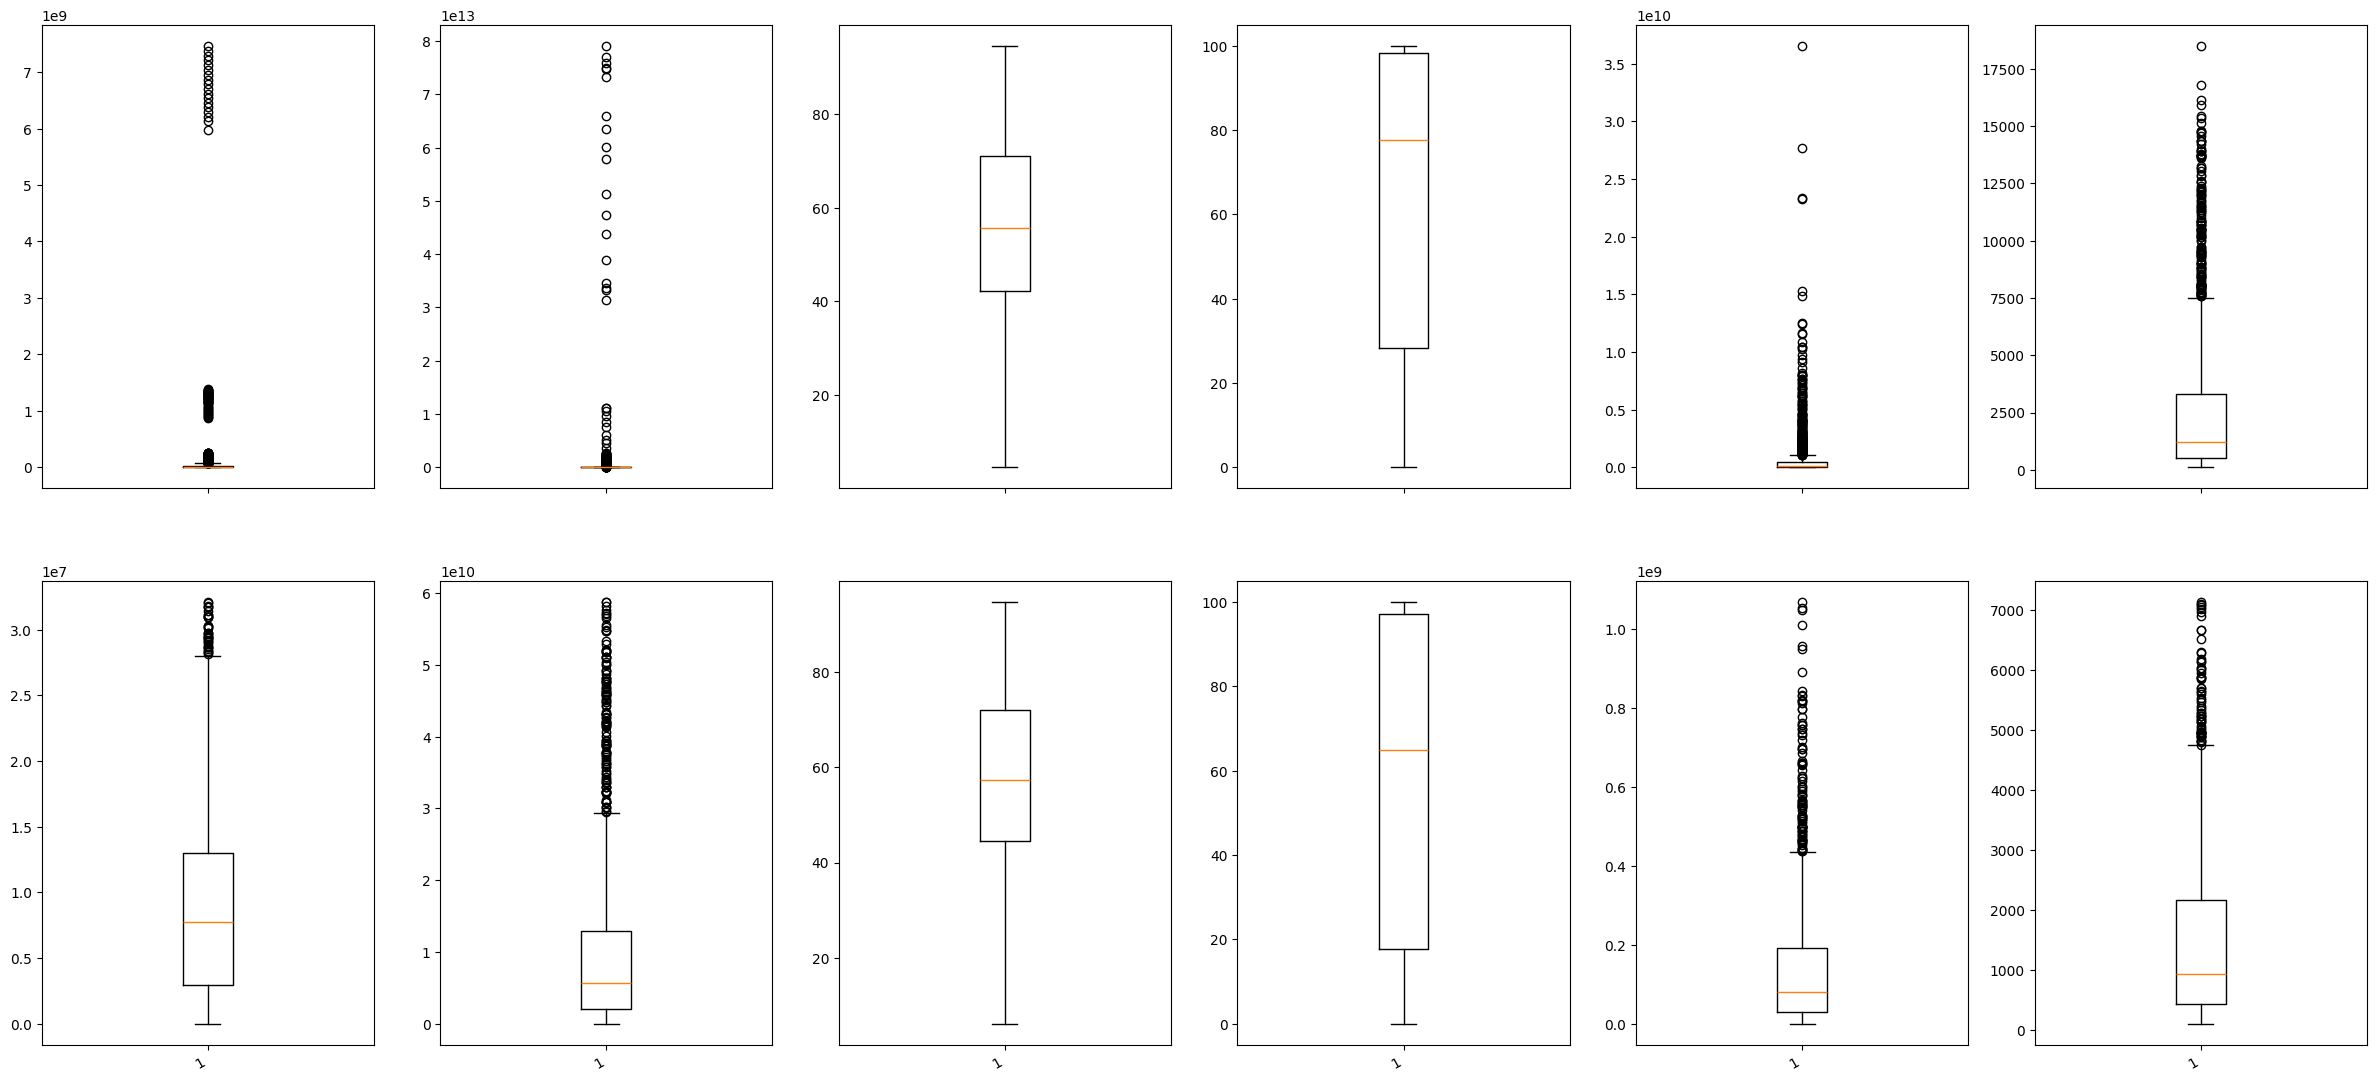

In [54]:
fig, axs = plt.subplots(2, 6, figsize=(30, 15))
fig.autofmt_xdate()

df = all_data_combined

axs[0,0].boxplot(df['population'])
axs[0,1].boxplot(df['gdp'])
axs[0,2].boxplot(df['rural_population_percent'])
axs[0,3].boxplot(df['electricity_access_percent'])
axs[0,4].boxplot(df['project_cost'])
axs[0,5].boxplot(df['gdp_per_capita'])

df = handle_outliers(df, 'rural_population_percent')
df = handle_outliers(df, 'electricity_access_percent')
df = handle_outliers(df, 'project_cost')
df = handle_outliers(df, 'gdp_per_capita')
df = handle_outliers(df, 'gdp')
df = handle_outliers(df, 'population')

axs[1,0].boxplot(df['population'])
axs[1,1].boxplot(df['gdp'])
axs[1,2].boxplot(df['rural_population_percent'])
axs[1,3].boxplot(df['electricity_access_percent'])
axs[1,4].boxplot(df['project_cost'])
axs[1,5].boxplot(df['gdp_per_capita'])

all_data_combined = df

# Scaling Feature

In [55]:
# minmaxscaller
final_data_scaled = all_data_combined
scaler = MinMaxScaler()
columns_to_scale = ['population','gdp','rural_population_percent','electricity_access_percent','project_cost','gdp_per_capita']
final_data_scaled[columns_to_scale] = scaler.fit_transform(final_data_scaled[columns_to_scale])
final_data_scaled


,country_name,year,population,gdp,rural_population_percent,electricity_access_percent,project_cost,gdp_per_capita
0,Albania,1992,0.100880,0.011481,0.639747,1.000000,0.040918,0.014951
1,Albania,1993,0.100264,0.020317,0.633523,1.000000,0.126404,0.038048
2,Albania,1994,0.099648,0.033224,0.627242,1.000000,0.102060,0.072049
3,Albania,1995,0.099033,0.040701,0.620939,1.000000,0.060487,0.092218
4,Albania,1996,0.098417,0.055870,0.614579,1.000000,0.186985,0.132956
...,...,...,...,...,...,...,...,...
1933,Zimbabwe,2011,0.426898,0.205517,0.687663,0.368937,0.015346,0.109628
1934,Zimbabwe,2013,0.445561,0.262647,0.691749,0.370705,0.019663,0.137775
1935,Zimbabwe,2014,0.455809,0.270131,0.693480,0.322932,0.029213,0.138595
1936,Zimbabwe,2015,0.466172,0.277178,0.694895,0.336934,0.015918,0.139096


# Load

#### Local

In [56]:
all_data_combined.to_csv('DataLoad/final_data.csv')
all_data_combined.to_parquet('DataLoad/final_data.parquet')
final_data_scaled.to_csv('DataLoad/final_data_scaled.csv')
final_data_scaled.to_parquet('DataLoad/final_data_scaled.parquet')

#### Cloud

In [ ]:
load_dotenv()
credentials_path = os.getenv('FIREBASE_CREDENTIALS_PATH')
cred = credentials.Certificate(credentials_path)
firebase_admin.initialize_app(cred)
bucket_name = os.getenv('BUKCET_NAME')
bucket = storage.bucket(bucket_name)


In [ ]:
# final_data
file_ref = bucket.blob('final_data.csv')
file_ref.upload_from_filename('DataLoad/final_data.csv')
print("File uploaded successfully!")

In [ ]:
# final_data_scaled
file_ref = bucket.blob('final_data_scaled.csv')
file_ref.upload_from_filename('DataLoad/final_data_scaled.csv')
print("File uploaded successfully!")